In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image

from torch.utils.data import Dataset, DataLoader

In [2]:
class ClefDataset(Dataset):
    def __init__(self, path, tokenizer, csv_filename='prompt-gt.csv', max_length=256, pad_token = "[EOS]", train=True, load_to_ram=True, valid_size = 0.15, random_seed=2204, transform=None):
        super().__init__()
        
        self.random_state = np.random.RandomState(random_seed)
        self.path = path
        self.load_to_ram = load_to_ram
        self.tokenizer = tokenizer
        self.tokenizer.enable_padding()
        self.tokenizer.enable_truncation(max_length=max_length)
        
        self.transform = transform
        self.to_tensor = T.ToTensor()
        
        self.prompts_info = pd.read_csv(self.path + f'/{csv_filename}', header=0, delimiter=';')
        
        self.train_size = int(self.prompts_info.shape[0] * (1 - valid_size))
        train_indexes = self.random_state.choice(self.prompts_info.shape[0], size=self.train_size, replace=False)

        if train:
            self.tokenized_prompts = self.tokenizer.encode_batch(self.prompts_info.iloc[train_indexes, 0].tolist())
            self.image_files = self.prompts_info.iloc[train_indexes, 1].tolist()
        else:
            self.val_size = self.prompts_info.shape[0] - self.train_size
            val_indexes = np.delete(np.arange(self.prompts_info.shape[0]), train_indexes)
            self.tokenized_prompts = self.tokenizer.encode_batch(self.prompts_info.iloc[val_indexes, 0].tolist())
            self.image_files = self.prompts_info.iloc[val_indexes, 1].tolist()
        
        self.prompts = []
        for prompt in self.tokenized_prompts:
            self.prompts.append(prompt.ids)

        if load_to_ram:
            self.images = self._load_images(self.image_files)
        

    def _load_images(self, image_files):
        images = []
        for filename in tqdm(image_files):
            image = Image.open(f'{self.path}/images/{filename}').convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, item):
        prompt = self.prompts[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.image_files[item]
            image = Image.open(f'{self.path}/images/{filename}').convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
        else:
            image = self.to_tensor(image)

        return prompt, image

In [3]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_pretrained("bert-base-multilingual-uncased")

In [4]:
train_dataset = ClefDataset(path='../data/train', tokenizer=tokenizer, train=True, load_to_ram=False)
val_dataset = ClefDataset(path='../data/train', tokenizer=tokenizer, train=False, load_to_ram=False)

In [5]:
train_dataset[0]

([101,
  69298,
  10144,
  16117,
  10171,
  122,
  33570,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0000]],
 
         [[0.0157, 0.0157, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0157, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0196],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0078, 0.0078, 0

In [11]:
pd.read_csv('../data/train/prompt-gt.csv', header=0, delimiter=';')

,Prompt,Filename
0,Generate an image containing a polyp.,clb0lbwzadoyc086u0brshvx5.jpg
1,Generate an image containing biopsy forceps.,clb0lbwzadoyc086u0brshvx5.jpg
2,Generate an image with 2 findings.,clb0lbwzadoyc086u0brshvx5.jpg
3,Generate an image with 1 instrument.,clb0lbwzadoyc086u0brshvx5.jpg
4,Generate an image with 1 polyp.,clb0lbwzadoyc086u0brshvx5.jpg
...,...,...
20236,Generate an image containing text.,clb0lbwypdods086u2txd5l85.jpg
20237,Generate an image with an abnormality with the...,clb0lbwypdods086u2txd5l85.jpg
20238,Generate an image from a colonoscopy procedure.,clb0lbwypdods086u2txd5l85.jpg
20239,Generate an image with an an abnormality locat...,clb0lbwypdods086u2txd5l85.jpg


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

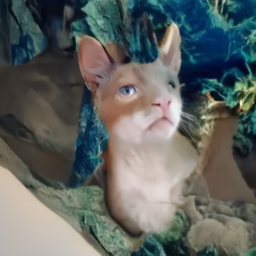

In [8]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
image = ddpm(num_inference_steps=50).images[0]
image

In [3]:
%pip install --upgrade tensorflow tensorboard torch torchtext torchvision torchaudio protobuf wandb

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.2
    Uninstalling wandb-0.15.2:
      Successfully uninstalled wandb-0.15.2
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1
    Uninstalling torchaudio-0.13.1:
      Successfully uninstalled torchaudio-0.13.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
import wandb

# Define a config dictionary object
config = {
    "hidden_layer_sizes": [32, 64],
    "kernel_sizes": [3],
    "activation": "ReLU",
    "pool_sizes": [2],
    "dropout": 0.5,
    "num_classes": 10,
}

# Pass the config dictionary when you initialize W&B
run = wandb.init(project="config_example2", config=config)

Thread SenderThread:
Traceback (most recent call last):
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 49, in run
    self._run()
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 100, in _run
    self._process(record)
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal.py", line 328, in _process
    self._sm.send(record)
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 385, in send
    send_handler(record)
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 589, in send_exit
    self._update_summary()
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 1137, in _update_summary
    with open(summary_path, "w") as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/mike/Diploma_HSE_ImageCLEFmed_2024_VQA_Image_Synthesis/src/wand

Problem at: /tmp/ipykernel_26735/3347990318.py 14 <module>


Traceback (most recent call last):
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 2219, in _atexit_cleanup
    self._on_finish()
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 2466, in _on_finish
    _ = exit_handle.wait(timeout=-1, on_progress=self._on_progress_exit)
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/lib/mailbox.py", line 298, in wait
    on_probe(probe_handle)
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 2430, in _on_probe_exit
    result = handle.wait(timeout=0, release=False)
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/lib/mailbox.py", line 281, in wait
    raise MailboxError("transport failed")
wandb.sdk.lib.mailbox.MailboxError: transport failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mike/.local/lib/python3.10/site-packages/wandb/sdk/wa

Error: An unexpected error occurred

In [5]:
from config.config import get_cfg_defaults

In [6]:
cfg = get_cfg_defaults()
cfg.merge_from_file("example.yaml")
cfg.freeze()
print(cfg)

NEW_KEY:
  HP1: 3
SYSTEM:
  NUM_GPUS: 2
  NUM_WORKERS: 4
TRAIN:
  HYPERPARAMETER_1: 0.1
  SCALES: (1, 2)


In [3]:
cfg

CfgNode({'SYSTEM': CfgNode({'NUM_GPUS': 2, 'NUM_WORKERS': 4}), 'TRAIN': CfgNode({'HYPERPARAMETER_1': 0.1, 'SCALES': (1, 2)})})

In [4]:
import wandb

# Define a config dictionary object

# Pass the config dictionary when you initialize W&B
run = wandb.init(project="config_example3", config=cfg)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mishac22. Use `wandb login --relogin` to force relogin
